<center>
<h1>The Full Machine Learning Lifecycle - How to Use Machine Learning in Production (MLOps)</h1>
<hr>
<h2>Exploratory Data Analysis</h2>
<hr>
 </center>

# Introduction
We will start our end-to-end ML project with an exploratory data analysis to get more familiar with the data and to look for patterns in the data that may be useful for our classification task. In this notebook, we will examine the structure of the dataset, aspects of data quality, as well as data distribution and correlations between features. Let´s get started...

In [1]:
import pandas as pd
import numpy as np
import os
import sys
import matplotlib.pyplot as plt
import seaborn as sns
sys.path.insert(1, os.path.join(sys.path[0], '..'))
sys.path.append('/cd4ml/plugins/')

from cd4ml.data_processing import get_data

sns.set()
%matplotlib inline

# Getting the data

In [2]:
# paths and variables
_raw_data_dir = '/data/batch1'   
_data_dir = '/data/' 

In [17]:
# get the data from storage
df = get_data(_raw_data_dir)
df.head()

,wt_sk,measured_at,wind_speed,power,nacelle_direction,wind_direction,rotor_speed,generator_speed,temp_environment,temp_hydraulic_oil,temp_gear_bearing,cosphi,blade_angle_avg,hydraulic_pressure,subtraction,categories_sk
0,1,2020-01-06 01:00:00.0000000 +01:00,0.524715,0.208155,233.506092,238.550624,0.789453,0.677639,5.283114,16.725045,40.292313,0.935662,-2.242540,189.344883,NaN,NaN
1,1,2020-01-06 01:10:00.0000000 +01:00,0.501737,0.204525,235.644635,240.006399,0.787370,0.654689,5.234789,16.697804,39.052409,0.921257,-2.525200,189.264131,NaN,NaN
2,1,2020-01-06 01:20:00.0000000 +01:00,0.486337,0.191243,239.441125,235.049440,0.775353,0.653553,4.974414,16.992438,38.731269,0.914137,-2.127490,190.702588,NaN,NaN
3,1,2020-01-06 01:30:00.0000000 +01:00,0.493992,0.164819,238.475559,242.042405,0.748940,0.637568,5.012806,17.303644,37.577535,0.919831,-1.377691,189.775681,NaN,NaN
4,1,2020-01-06 01:40:00.0000000 +01:00,0.496451,0.185796,238.672943,234.940960,0.760887,0.652163,5.005830,17.183339,37.631812,0.918228,-2.430379,188.614471,NaN,NaN


# Structure of the dataset
Let's start our EDA by looking at the structure of the dataset.

In [4]:
df.shape

(52383, 16)

As we can see, the dataset contains 52383 rows and 16 feature columns.

The table below lists for each feature a short description, alongside its unit and data type.

| Column name        | Description                                                                           | Unit | Data Type |
|:-------------------|:--------------------------------------------------------------------------------------|:-----|:----------|
| wt_sk              | Unique device identifier, equivalent to device name                             | -    | float     |
| measured_at        | Data timestemp in UTC format                                                          | -    | string    |
| wind_speed         | Average apparent wind speed measured by nacelle anemometer, normalised to rated value | m/s  | float     |
| power              | Average measured power production, normalised to rated max power                      | W    | float     |
| nacelle_direction  | Average position of nacelle relative to North (E=90°)                                 | °    | float     |
| wind_direction     | Average direction of incoming wind relative to North (E=90°)                          | °    | float     |
| rotor_speed        | Average revolutions per minute of the low speed rotor, normalised to rates RS         | -    | float     |
| generator_speed    | Average revolutions per minute of the generator, normalised to rated GS               | -    | float     |
| temp_environment   | Average outside temperature on nacelle height                                         | °C   | float     |
| temp_hydraulic_oil | Average oil temperature                                                               | °C   | float     |
| temp_gear_bearing  | Average gear temperature                                                              | °C   | float     |
| cosphi             | Average power factor of device                                                        | -    | float     |
| blade_angle_avg    | Average pitching angles, averaged over blades                                         | °    | float     |
| hydraulic_pressure | Average pressure in hydraulic circuit                                                 | mBar | float     |
| subtraction        | Error flag (NaN: no error, 0/1: error)                                                | -    | float     |
| categories_sk      | Categorisation of error type                                                          | -    | float     |


In [5]:
df.dtypes

wt_sk                   int64
measured_at            object
wind_speed            float64
power                 float64
nacelle_direction     float64
wind_direction        float64
rotor_speed           float64
generator_speed       float64
temp_environment      float64
temp_hydraulic_oil    float64
temp_gear_bearing     float64
cosphi                float64
blade_angle_avg       float64
hydraulic_pressure    float64
subtraction           float64
categories_sk         float64
dtype: object

Of the 16 features, 15 are numerical. The only non-numerical column is the column `measured_at`. Let's first have a look at this one.

### Non-numerical features

In [6]:
df['measured_at'].describe()

count                                  52383
unique                                 13098
top       2020-01-06 01:00:00.0000000 +01:00
freq                                       4
Name: measured_at, dtype: object

The feature `measured_at` represents the timestamp in UTC format corresponding to the measurement time. The number of unique entries is lower than the total count as the dataset contains entries for multiple wind turbines, recorded at the same time.

Since we want to do row-level predictions, we will remove the timestamps from the analysis.

In [7]:
df.drop("measured_at", axis=1, inplace=True)

### Numerical features

Now, we will turn our attention to the numerical features. More specifically, we will look at the number of unique values for each feature.

In [8]:
vals_unique = df.select_dtypes(include="number").nunique().sort_values()
print(vals_unique)

subtraction               2
wt_sk                     4
categories_sk             6
wind_speed            52383
power                 52383
nacelle_direction     52383
wind_direction        52383
rotor_speed           52383
generator_speed       52383
temp_environment      52383
temp_hydraulic_oil    52383
temp_gear_bearing     52383
cosphi                52383
blade_angle_avg       52383
hydraulic_pressure    52383
dtype: int64


We observe that `subtraction` is a binary feature. `wt_sk` and `categories_sk` appear to be ordinal, and the remaining features are of continuous nature. We thus have 3 categorical features and 12 continuous features.

The feature `categories_sk` describes the type of error code of the wind turbine. This is the target which we want to predict. The feature `subtraction` indicates if an error code was received. Since this information is already contained in `categories_sk`, we will exlude `subtraction` from further analysis.

In [9]:
df.drop("subtraction", axis=1, inplace=True)

# Data quality
Now, we will have a look at the quality of the dataset.

### Duplicate rows

In [10]:
rows_duplicate = df.duplicated().sum()
print("Number of duplicate rows:", rows_duplicate)

Number of duplicate rows: 0


Great. No duplicates!

### Missing values

In [11]:
df.isna().mean().sort_values()

wt_sk                 0.000000
wind_speed            0.000000
power                 0.000000
nacelle_direction     0.000000
wind_direction        0.000000
rotor_speed           0.000000
generator_speed       0.000000
temp_environment      0.000000
temp_hydraulic_oil    0.000000
temp_gear_bearing     0.000000
cosphi                0.000000
blade_angle_avg       0.000000
hydraulic_pressure    0.000000
categories_sk         0.943359
dtype: float64

Most of the features are complete, but `categories_sk` has less than 5% non-nan entries. The reason for this is that normal operation (i.e. non-error) is encoded as `NaN`.

In [12]:
df["categories_sk"].value_counts(dropna=False)

NaN     49416
5.0      2415
20.0      235
3.0       175
19.0      123
24.0       10
22.0        9
Name: categories_sk, dtype: int64

### Erroneous recordings
Plotting each feature can help in identifying obvious data errors.

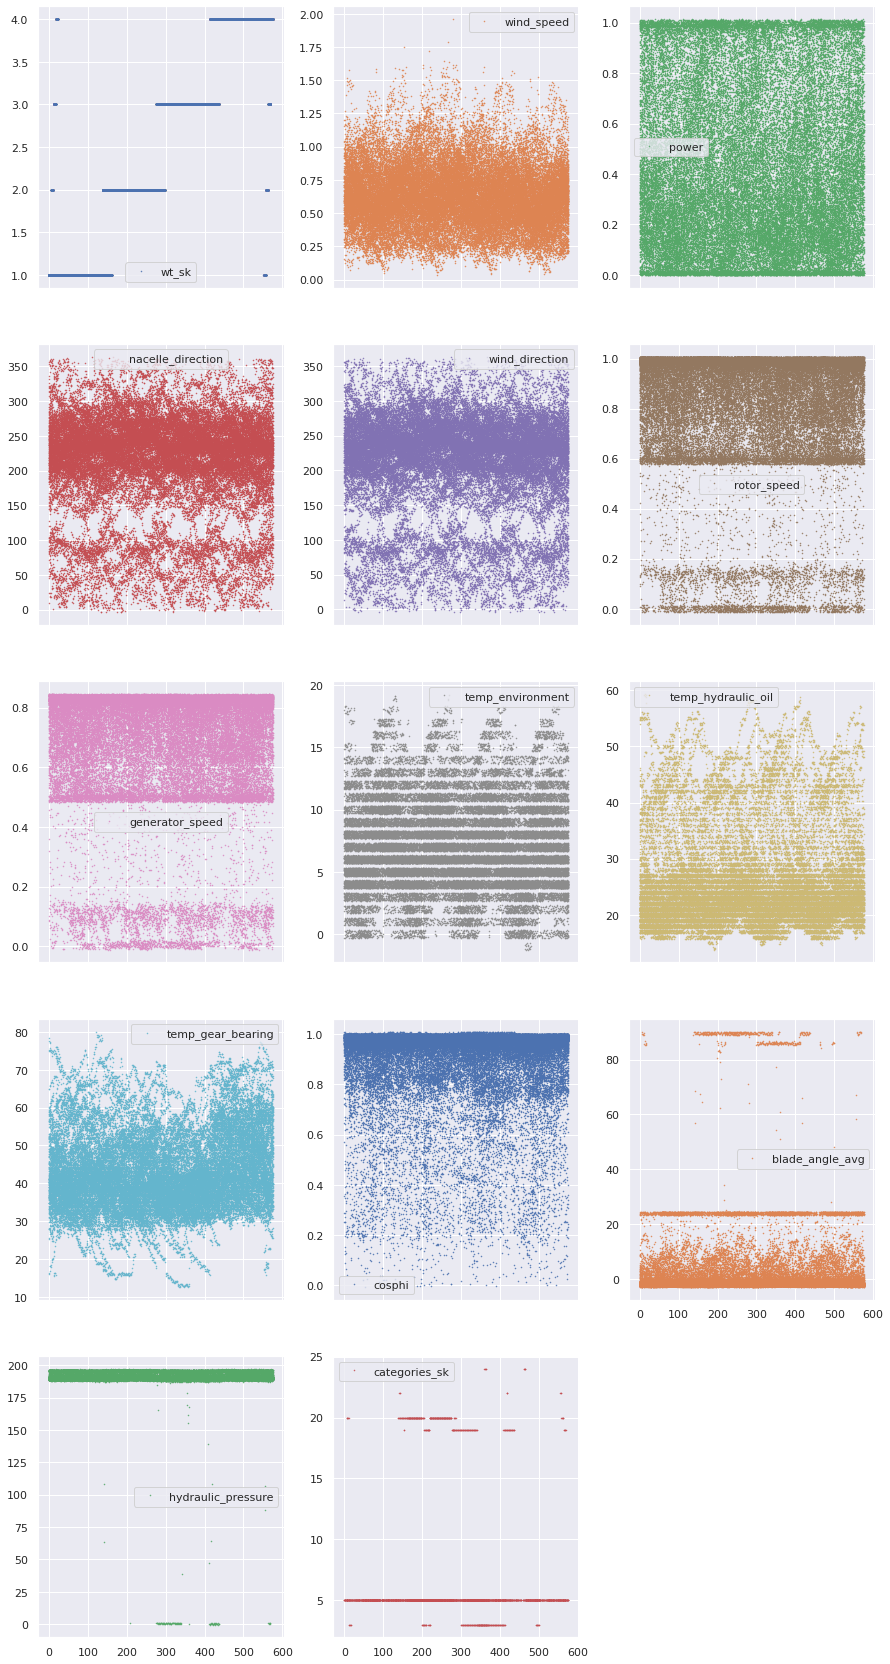

In [13]:
df.plot(lw=0,
       marker=".",
       subplots=True,
       layout=(-1, 3),
       figsize=(15, 30),
       markersize=1)
plt.show()

Nothing seems to be obsously wrong. It can be tricky to discern an outlier (which we want to keep) from a truly erroneous entry (such as a negative wind speed). However, there are certainly some interesting things to be noted here. This is, where we start looking at the content of the data.

# Data content

### Feature correlations
Let's have a look at how the features are correlated with each other.

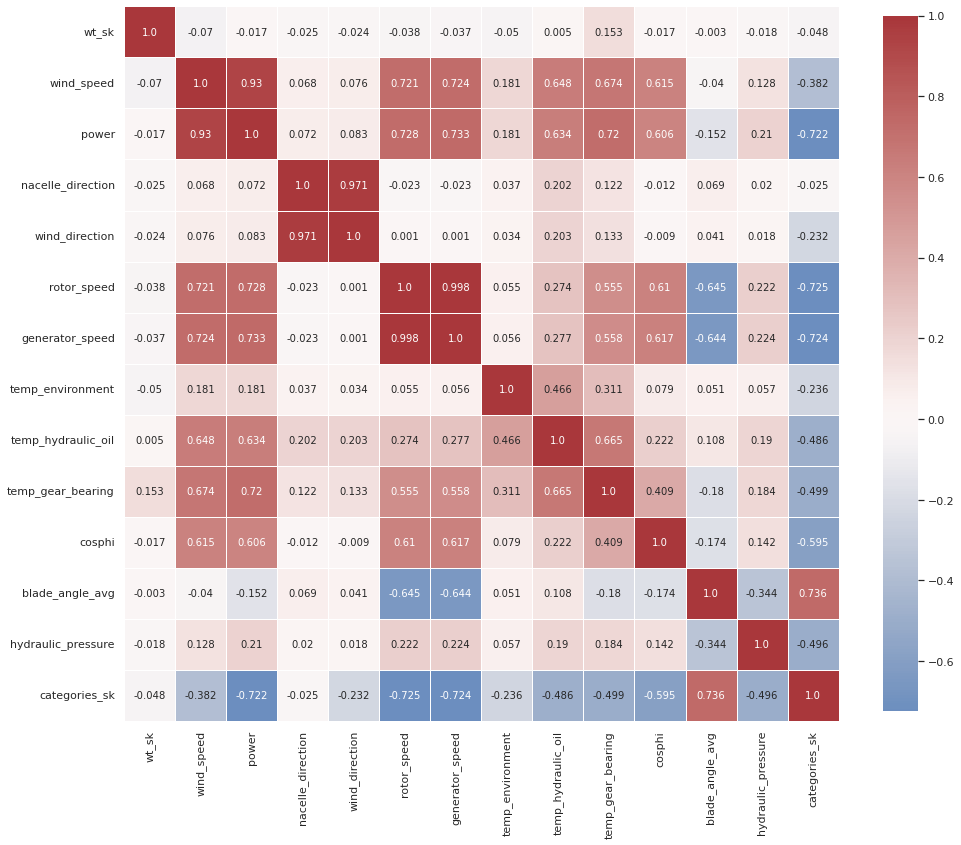

In [15]:
feat_correlations = df.corr(method="pearson")

plt.figure(figsize=(16, 16))
sns.heatmap(feat_correlations,
           square=True,
           center=0,
            annot=np.round(feat_correlations,3),
           fmt="",
           linewidths=.5,
           cmap="vlag",
           cbar_kws={"shrink": 0.8})
plt.show()

Some of the features seem to be strongly correlated, such as `rotor_speed` and `generator_speed`.

Of special interest is of course the correlation with the target variable `categories_sk`.

In [16]:
feat_correlations["categories_sk"].sort_values(ascending=False)

categories_sk         1.000000
blade_angle_avg       0.736499
nacelle_direction    -0.025299
wt_sk                -0.048228
wind_direction       -0.231580
temp_environment     -0.236049
wind_speed           -0.382417
temp_hydraulic_oil   -0.486159
hydraulic_pressure   -0.496261
temp_gear_bearing    -0.499036
cosphi               -0.594933
power                -0.722247
generator_speed      -0.724286
rotor_speed          -0.724601
Name: categories_sk, dtype: float64

# Summary
This completes our Exploratory Data Analysis. You should now have a better understanding of the dataset and some first ideas what processing steps would be useful and which features might be informative for our classification task.